In [515]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import category_encoders as ce

# для удобства просмотра
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_rows', 200)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# инструменты для лингвистического анализа:
import string
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# from textblob import TextBlob, Blobber
# from textblob.sentiments import NaiveBayesAnalyzer
from afinn import Afinn
nltk.download('vader_lexicon')

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # инструмент для масштабирования каждой функции до заданного диапазона

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [516]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [517]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [518]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [519]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [520]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom,581,2/19/2016,8.400,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.000,"[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']",531 day,51.508,-0.144
1,130 134 Southampton Row Camden London WC1B 5AF United Kingdom,299,1/12/2017,8.300,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.300,"[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']",203 day,51.521,-0.123


In [521]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [522]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.100,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices,52,16670,Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again,62,1,"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']",13 days,45.533,9.171
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Netherlands,612,12/12/2016,8.600,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ', ' Stayed 1 night ']",234 day,52.386,4.834


In [523]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [524]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [525]:
# ВАЖНО! Для корректной обработки признаков объединяем трейн и тест в один датасет.
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [526]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [527]:
# hotels['lat'] = hotels['lat'].fillna(0, inplace=True)
# hotels['lng'] = hotels['lng'].fillna(0, inplace=True)

In [528]:
hotels.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

Тут видно, что сравнительно большие объёмы данных (опыт показал и наиболее эффективной для модели) находятся в столбцах:
* negative_review -                               330011
* positive_review -                               412601
* tags -                                           55242

<AxesSubplot:>

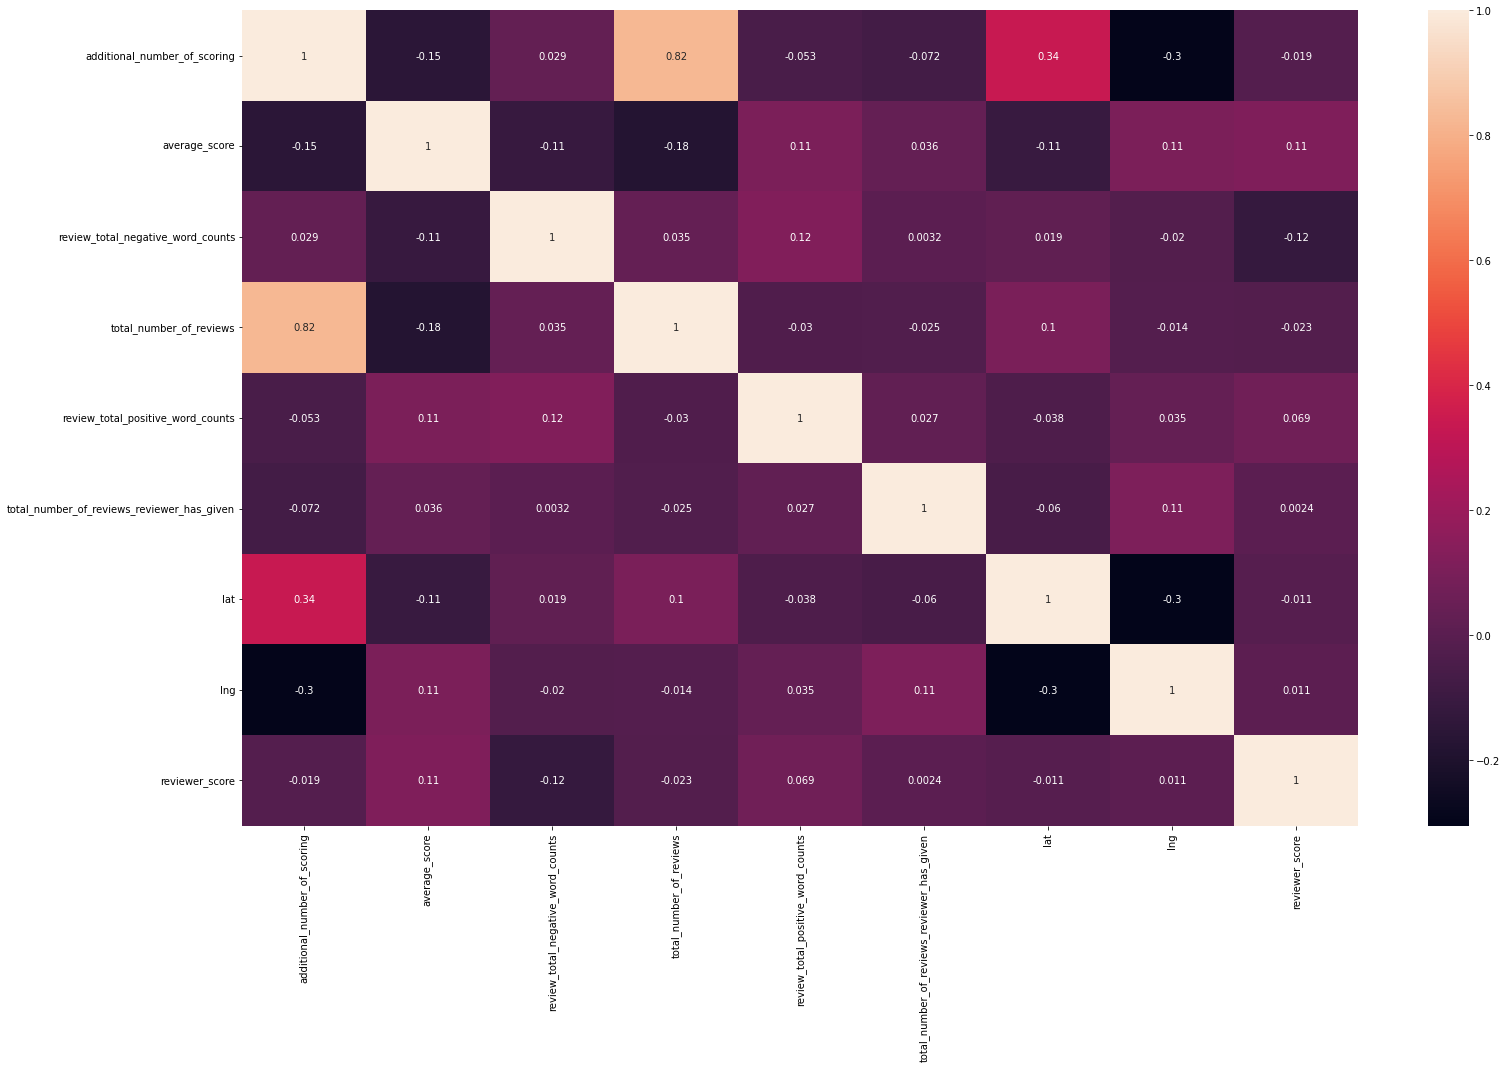

In [529]:
plt.rcParams['figure.figsize'] = (25,15)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True) # , cmap='coolwarm', linewidth=0.3, linecolor='gray'

## Удаление дубликатов

In [530]:
# Удаление дубликатов
print(f'Число записей: {hotels.shape[0]}')

dupl_columns = list(hotels.columns)

mask_d = hotels.duplicated(subset=dupl_columns)
hotels_duplicates = hotels[mask_d]
print(f'Число найденных дубликатов: {hotels_duplicates.shape[0]}')

hotels_dedupped = hotels.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {hotels_dedupped.shape[0]}')

Число записей: 515738
Число найденных дубликатов: 336
Результирующее число записей: 515402


## Признак hotel_address

#### Попробуем использовать индекс как определение региона расположения (чисто индекс показал ухудшение, пока закоментировал)
 Реализация кода для ускорения взята у MARGARITA KR (https://www.kaggle.com/code/margaritakr/project-3-booking-com-margaritak), с доработками по своему разумению :)

* http://ruqrz.com/pochtovye-indeksy-londona/ - Англия
* https://ru.youbianku.com/%D0%9D%D0%B8%D0%B4%D0%B5%D1%80%D0%BB%D0%B0%D0%BD%D0%B4%D1%8B - Нидерланды
* https://ru.youbianku.com/%D0%90%D0%B2%D1%81%D1%82%D1%80%D0%B8%D1%8F - Австрия
* https://ru.youbianku.com/%D0%98%D1%82%D0%B0%D0%BB%D0%B8%D1%8F - Италия
* https://ru.youbianku.com/%D0%98%D1%81%D0%BF%D0%B0%D0%BD%D0%B8%D1%8F - Испания
* https://ru.youbianku.com/%D0%A4%D1%80%D0%B0%D0%BD%D1%86%D0%B8%D1%8F - Франция

In [531]:
# Для удобства просмотра и дальнейшей работы сформируем массив адресов
addresses = pd.Series(hotels['hotel_address'].unique())

# hotels['hotel_address'][200].split()
# addresses[0].split()[-4:-2] 

In [532]:
def get_zipcode(address):
    """Извлечение почтового индекса из строки с адресом."""
    address_list = address.split()
    zipcode_place = {
        'Kingdom': -4, 
        'Spain': -3, 
        'France': -3, 
        'Austria': -3, 
        'Netherlands': -4, 
        'Italy': -3
    }
    zipcode = str(address_list[zipcode_place[address_list[-1]]])
    #return zipcode
    if address_list[-1] == 'Kingdom' and zipcode[-1].isalpha():
        return zipcode[:-1]
        #return zipcode + " " + address_list[-3]
    else:
        return zipcode

# Показало ухудшение, посему закоментил, может потом пригодится    
# добавляется почтовый индекс отеля как идентификатор района:
# hotels['hotel_postcode'] = hotels['hotel_address'].apply(get_zipcode).astype('category')
# hotels['hotel_zip_code'] = hotels['hotel_postcode'].cat.codes
# hotels['hotel_zip_code'] = hotels['hotel_zip_code'].astype('int32')
# hotels.drop(['hotel_postcode'],axis=1,inplace=True)

In [533]:
# Показало ухудшение, посему закоментил, может потом пригодится
# кодируем признак почтового индекса района отеля методом двоичного кодирования
# bin_encoder = ce.BinaryEncoder(cols=['hotel_postcode']) # указываем столбец для кодирования
# type_bin = bin_encoder.fit_transform(hotels['hotel_postcode'])
# hotels = pd.concat([hotels, type_bin], axis=1)

# hotels
# hotels['hotel_zip_code']

In [534]:
#выделяем страну и название города из признака hotel_address
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split()[-5] if x.endswith('United Kingdom') else x.split()[-2])
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
hotels.drop('hotel_address',axis=1, inplace=True)

In [535]:
hotels['hotel_city'].unique().tolist()
# В наборе данных найдено 6 городов-столиц: ['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'] 

['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']

In [536]:
# Использую рекомендации Сергея Добдина (ментор) из переписки в Slack с Пензиным Константином
values_lat = {
    'Milan': 45.4642700,
    'Amsterdam': 52.3740300,
    'Barcelona': 41.3887900,
    'London': 51.5085300,
    'Paris': 48.8534100,
    'Vienna': 48.2084900
}

values_lng = {
    'Milan': 9.1895100,
    'Amsterdam': 4.8896900,
    'Barcelona': 2.1589900,
    'London': -0.1257400,
    'Paris': 2.3488000,
    'Vienna': 16.3720800
}

# заполняем широту
# hotels['lat'] = hotels[['hotel_city','lat']].apply(lambda x: values_lat[x.hotel_city] if np.isnan(x.lat) else x.lat, axis=1)
# заполняем долготу
# hotels['lng'] = hotels[['hotel_city','lng']].apply(lambda x: values_lng[x.hotel_city] if np.isnan(x.lng) else x.lng, axis=1)

# (Убрал из кода просто добавление координат не даёт улучшение, наоборот ухудшило скоринг.)

In [537]:
# кодировка города отеля методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['hotel_city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['hotel_city'])
hotels = pd.concat([hotels, type_bin], axis=1)

# так почему-то результат получился хуже, пока закоментировал
# hotels['hotel_city'] = hotels['hotel_city'].astype('category')   
# hotels['hotel_city'] = hotels['hotel_city'].cat.codes
# hotels['hotel_city'] = hotels['hotel_city'].astype('int')
# hotels.drop(['hotel_postcode'],axis=1,inplace=True)

# hotels['hotel_country'] = hotels['hotel_country'].astype('category')
# hotels['hotel_country'] = hotels['hotel_country'].cat.codes
# hotels['hotel_country'] = hotels['hotel_country'].astype('int')

## Признак review_date

In [538]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], infer_datetime_format=True)
hotels['review_month'] = hotels['review_date'].dt.month
# извлекаем день недели из даты
hotels['day_of_week'] = hotels['review_date'].dt.dayofweek
display(hotels['review_month'].value_counts())
# hotels['review_month'].head()

8     50672
7     49318
5     46490
10    43843
6     42896
4     42883
9     42428
1     42151
3     41110
12    39607
2     38370
11    35970
Name: review_month, dtype: int64

In [539]:
# Кодируем признак в высокий или низкий сезон состоялось посещение отеля
# Выбраны первые четыре месяца в рейтинге в сторке кода выше [8,7,5,10]. Не очевидно, но показало лучший результат. 
hotels['high_season'] = hotels['review_month'].apply(lambda x: 1 if x in [8,7,5,10] else 0)

In [540]:
# кодировка дня недели методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['day_of_week']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['day_of_week'])
hotels = pd.concat([hotels, type_bin], axis=1)

# так почему-то результат получился хуже, пока закоментировал
# hotels['day_of_week'] = hotels['day_of_week'].astype('category')
# hotels['day_of_week'] = hotels['day_of_week'].cat.codes
# hotels['day_of_week'] = hotels['day_of_week'].astype('int')


In [541]:
# кодировка месяца методом однократного кодирования OneHotEncoder
encoder = ce.OneHotEncoder(cols=['review_month']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['review_month'])
hotels = pd.concat([hotels, type_bin], axis=1)

# так почему-то результат получился хуже, пока закоментировал
# hotels['review_month'] = hotels['review_month'].astype('category')
# hotels['review_month'] = hotels['review_month'].cat.codes
# hotels['review_month'] = hotels['review_month'].astype('int')


In [542]:
## hotels.drop(['review_date','review_month', 'day_of_week', 'lat', 'lng'],axis=1,inplace=True)
# удаляем признак даты отзыва и координаты
hotels.drop(['review_date','review_month', 'day_of_week', 'lat', 'lng'],axis=1,inplace=True)

## Признак reviewer_nationality

In [543]:
# данные очищаются от лишних пробелов
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x.strip())

# отмечается является ли рецензент гражданином страны, в которой находится отель
hotels['is_citizen'] = hotels['reviewer_nationality'] == hotels['hotel_country']
hotels['is_citizen'] = hotels['is_citizen'].astype('int')

# оставляются только 10 самых популярных национальностей, остальные заполняются значением 'other'
top_nations = list(hotels['reviewer_nationality'].value_counts()[:10].index)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in top_nations else 'other')

In [544]:
# кодируется признак национальности рецензента методом двоичного кодирования
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
data = pd.concat([hotels, type_bin], axis=1)

In [545]:
# удаляются преобразованные признаки
hotels.drop(['hotel_city','hotel_country','reviewer_nationality'],axis=1,inplace=True)

## Признаки Отрицательный и Положительный отзывы

In [546]:
# убраются пробелы в начале и конце строки 
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.strip())
hotels['positive_review'] = hotels['positive_review'].apply(lambda x: x.strip())

In [547]:
# проверка часто встречающихся негативных отзывов
# hotels['negative_review'].value_counts().nlargest(150)                                                 
# в столбце негативные отзывы присутсвуют на самом деле отрицание негатива.

In [548]:
# Создаётся список false_negative, в котором присутсвует ложноотрицательный отзыв. (Не самая лучшая реализация, но уж оставил так.)
negative_review_freq = hotels['negative_review'].value_counts().nlargest(150).index[:150].tolist()

negative = ['Small room', 'Breakfast', 'Location', 'Everything', 'Price', 'Small rooms', 'Leaving', 'Expensive', 'Room size',\
           'Having to leave', 'Very small room', 'Staff', 'See above', 'Room was very small', 'Expensive breakfast', \
           'The price', 'small room', 'Room too small', 'Pillows', 'Not applicable', 'breakfast', 'Room very small',\
           'Parking', 'Breakfast not included', 'Room was small', 'Very small rooms', 'Size of the room', 'Size of room',\
           'Breakfast too expensive', 'As above', 'Wifi', 'location', 'No parking', 'The breakfast', 'No gym', 'Price of breakfast',\
           'Small bathroom', 'Noise', 'The room was very small', 'Bathroom', 'Poor breakfast', 'Room a bit small',\
           'Very expensive', 'Breakfast could be better', 'Room was a bit small', 'Bed', 'The location', 'Rooms are very small',\
           'No swimming pool', 'The weather', 'Breakfast was expensive', 'small rooms', 'No pool', 'Rooms are small',\
           'No bar', 'Room', 'Tiny room', 'A bit expensive', 'Cost', 'Bar prices', 'The size of the room', 'No free wifi',\
           'No comment', 'The bed', 'No air conditioning', 'Noisy', 'Breakfast could have been better', 'The room was small',\
           'All', 'The room', 'Room was a little small', 'Room service', 'Cleanliness', 'The view', 'Every thing', 'Service']
false_negative = list(filter(lambda x: x not in negative, negative_review_freq))

display(false_negative)
print('_________________________________________________________________')
print(f'Было выбрано {len(false_negative)} ложноотрицательных отзыва.')

['No Negative',
 'Nothing',
 'nothing',
 'None',
 'N A',
 '',
 'Nothing really',
 'N a',
 'All good',
 'No complaints',
 'Nothing at all',
 'Nothing to dislike',
 'none',
 'Nil',
 'Everything was perfect',
 'Can t think of anything',
 'n a',
 'Absolutely nothing',
 'Everything was great',
 'Nothing to complain about',
 'Nothing not to like',
 'NA',
 'I liked everything',
 'NOTHING',
 'No',
 'Everything was good',
 'Liked everything',
 'Not much',
 'Nothing all good',
 'Nothing in particular',
 'Everything was fine',
 'Na',
 'All was good',
 'Nothing it was perfect',
 'Non',
 'Nothing comes to mind',
 'There was nothing I didn t like',
 'No complaints at all',
 'Nothing everything was perfect',
 'We liked everything',
 'Nothing I didn t like',
 'No negatives',
 'There was nothing to dislike',
 'Nothing everything was great',
 'nothing really',
 'Nothing to report',
 'Not a thing',
 'It was all good',
 'There was nothing we didn t like',
 'Loved everything',
 'No thing',
 'no complaints'

_________________________________________________________________
Было выбрано 74 ложноотрицательных отзыва.


In [549]:
# Создаётся признак наличия либо отсутствия негативного отзыва 
# (при добавлении новых признаков связанных с эмоциями, начал давать корелляцию чуть меньше 0.7 с другими признаками, но оставлю.)

hotels['negative_review_exists'] = hotels['negative_review'].apply(lambda x: 0 if x in false_negative else 1 )
hotels['negative_review_exists'].mean()

0.6876825054581978

In [550]:
# Проверка часто встречающихся позитивных отзывов и сразу подготовка к работе, отбросить влияние размера шрифта.
# Тут больше соответсвия названия столбцу, но всё же есть записи "не по адресу".
hotels['positive_review'] = [x.lower() for x in hotels['positive_review']]
# hotels['positive_review'].value_counts().nlargest(150).index[:150].tolist()

In [551]:
# Создаётся список false_negative, в котором присутсвует ложноотрицательный отзыв. (Не самая лучшая реализация, но уж оставил так.)
nopositive_review_freq = hotels['positive_review'].value_counts().nlargest(150).index[:150].tolist()

nopositive = ['no positive', 'nothing', 'not much', 'nothing at all']
false_positive = list(filter(lambda x: x in nopositive, nopositive_review_freq))

display(false_positive)
print('_________________________________________________________________')
print(f'Было выбрано {len(false_positive)} ложноположительных отзыва.')

['no positive', 'nothing', 'not much', 'nothing at all']

_________________________________________________________________
Было выбрано 4 ложноположительных отзыва.


In [552]:
hotels['positive_review_exists'] = hotels['positive_review'].apply(lambda x: 0 if x in false_positive else 1 )
hotels['positive_review_exists'].mean()

0.9265363420961806

In [553]:
# Понравилось у Константина Пензина https://www.kaggle.com/code/constantinvp/project-3
# Вычислим долю слов положительных комментариев среди всех комментариев. 
# Пометим строку, если количество слов в пложительном комментарии преобладает над количеством слов в отрицательном.

hotels['review_total_positive_word_counts_norm']  = pd.DataFrame(
    MinMaxScaler().fit_transform(pd.DataFrame(hotels['review_total_positive_word_counts'])),
    columns=['review_total_positive_word_counts'])

hotels['review_total_negative_word_counts_norm']  = pd.DataFrame(
    MinMaxScaler().fit_transform(pd.DataFrame(hotels['review_total_negative_word_counts'])),
    columns=['review_total_negative_word_counts'])

hotels['review_total_word_diff_norm'] = hotels['review_total_positive_word_counts_norm'] - hotels['review_total_negative_word_counts_norm']

hotels['more_positive'] = hotels['review_total_word_diff_norm'].apply(lambda x: 1 if x >= 0 else 0)

hotels.drop(
    ['review_total_positive_word_counts_norm', 'review_total_negative_word_counts_norm'], 
    axis=1, inplace=True)

hotels['review_total_word_sum'] = \
    hotels['review_total_positive_word_counts'] + \
    hotels['review_total_negative_word_counts']

# пополам отрицательных и положительных
hotels['positive_words_proportion'] = hotels.apply( lambda x: 0.5 if x['review_total_word_sum'] == 0 \
    else x['review_total_positive_word_counts'] / x['review_total_word_sum'],axis=1)

hotels.drop('review_total_word_sum', axis = 1, inplace=True)

## Признак tags

In [554]:
# *************** Тут остатки кода разведочного анализа *****************************************************************
# status_1 = set()
# status_1.update(hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' ")[0]))
# display(status_1)
# display(len(status_1))
# 
# status_2 = set()
# status_2.update(hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' ")[1] if len(x[3:-3].split(" ', ' "))>1 else 0))
# display(status_2)
# display(len(status_2))
# 
# status_3 = set()
# status_3.update(hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' ")[2] if len(x[3:-3].split(" ', ' "))>2 else 0))
# display(status_3)
# display(len(status_3))
# 
# status_4 = set()
# status_4.update(hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' ")[3] if len(x[3:-3].split(" ', ' "))>3 else 0))
# display(status_4)
# display(len(status_4))
# 
# status_5 = set()
# status_5.update(hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' ")[4] if len(x[3:-3].split(" ', ' "))>4 else 0))
# display(status_5)
# display(len(status_5))
# 
# status_6 = set()
# status_6.update(hotels['tags'].apply(lambda x: x[3:-3].split(" ', ' ")[5] if len(x[3:-3].split(" ', ' "))>5 else 0))
# display(status_6)
# display(len(status_6))
# ****************************************************************************************************************************

# Проведённый разведочный анализ показал, что первые записи в тэгах отражают 
# статус поездки (работа или отдых - status_trip) и 
# состав группы (семья, группа, пара и т.п. - status_group)

# Создаём списки выявленных категорий
status_trip = ['Business trip', 'Leisure trip']

status_group = ['Couple',
    'Family with older children',
    'Family with young children',
    'Group',    
    'Solo traveler',
    'Travelers with friends',
    'With a pet']    

In [555]:
def get_trip_status(t):
    # Функция выбирает из тегов цель поездки  'Business trip' или 'Leisure trip'        
    sm_t = t[3:-3].split(" ', ' ")[0]
       
    if sm_t in status_trip:  
        if sm_t == status_trip[0]:
            return 1
        elif sm_t == status_trip[1]:
            return 2
    else: return 0 
    
# *******************************************************************************************
def get_group_status(t):
    # Функция выбирает из тегов совпадение в status_group и кодирует или выдаёт ноль         
    sm_t = t[3:-3].split(" ', ' ")[0]
       
    if sm_t in status_trip:  
        if sm_t == status_trip[0]:
            return 1
        elif sm_t == status_trip[1]:
            return 2
        elif sm_t == status_trip[2]:
            return 3
        elif sm_t == status_trip[3]:
            return 4
        elif sm_t == status_trip[4]:
            return 5
        elif sm_t == status_trip[5]:
            return 6
    else: return 0

# *******************************************************************************************

# Создаётся новый признак: trip_status -  отражающая цель поездки.              
hotels['trip status'] = hotels['tags'].apply(get_trip_status) 

# Создаётся новый признак: group_status -  отражающая состав группы.
hotels['group_status'] = hotels['tags'].apply(get_group_status) 

In [556]:
def get_days(t): 
    # Функция выбирает из тегов количество дней проживания или выдаёт ноль
    sm_t = t[3:-3].split(" ', ' ")    
    for num in range(len(sm_t)):  
        if sm_t[num].split()[0] == "Stayed":
            return int(sm_t[num].split()[1])
    return 0

# Создаётся новый признак: days - количество дней проживания. 
hotels['days'] = hotels['tags'].apply(get_days)

# Кодируются двоично все теги
bin_encoder = ce.BinaryEncoder(cols=['tags']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['tags'])
hotels = pd.concat([hotels, type_bin], axis=1)

# (признак 'days' - количество дней проживания, показал хороший скоринг)

In [557]:
# убираются прямые скобки
hotels['tags'] = hotels['tags'].apply(lambda x: x.strip('[]'))
# убираются кавычки и пробелы
hotels['tags'] = hotels['tags'].apply(lambda x: [w.strip(" '") for w in x.split(',')])
hotels['tags'].head()

0                                                            [Leisure trip, Couple, Double Room, Stayed 2 nights]
1                                                              [Leisure trip, Group, Triple Room, Stayed 1 night]
2                       [Business trip, Solo traveler, Twin Room, Stayed 1 night, Submitted from a mobile device]
3                                                 [Leisure trip, Couple, Ambassador Junior Suite, Stayed 1 night]
4    [Business trip, Solo traveler, Classic Double or Twin Room, Stayed 2 nights, Submitted from a mobile device]
Name: tags, dtype: object

In [558]:
# считается количество одинаковых тегов
tags_dict = {}
def fill_tags_dict(x):
    for elem in x:
        if elem in tags_dict :
            tags_dict[elem] = tags_dict[elem] + 1
        else:
            tags_dict[elem] = 1
    return x
hotels['tags'].apply(fill_tags_dict) 

# удаляются использованные части тегов по статусу, по группам проживания, 
[tags_dict.pop(key, None) for key in status_trip] 
[tags_dict.pop(key, None) for key in status_group] # удаляются использованные части тегов 
[tags_dict.pop(key, None) for key in ['Stayed 1 night', 'Stayed 2 nights', 'Stayed 3 nights',\
                                      'Stayed 4 nights','Stayed 5 nights','Stayed 6 nights','Stayed 7 nights']]

# [tags_dict.pop(key, None) for key in ['Submitted from a mobile device']]

len(tags_dict)

2412

In [559]:
# hotels['Submitted from a mobile device'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

# hotels['Submitted from a mobile device'] 

In [560]:
# создаётся DataFrame, отсортированный по частоте втречаемости тегов
tags_count = pd.DataFrame(tags_dict,index=['count']).transpose()
tags_sorted = tags_count.sort_values(by='count', ascending=False).head(40)

# определяю вес часто встречающихся тегов (применения положительного пока нет)
# tags_sorted['count_dolja'] = round(tags_sorted['count']/tags_sorted['count'].sum()*100, 3)
# tags_sorted.head(40)

In [561]:
# создаётся список наиболее часто встречающихся тегов
tags_40 = list(tags_sorted.index)

# кодируются наиболее часто встречающиеся теги (с учётом веса, хуже)
for tag in tags_40:
    hotels[tag] = hotels['tags'].apply(lambda x: 1 if tag in x else 0)
    # hotels[tag] = hotels['tags'].apply(lambda x: tags_sorted.loc[tag]['count_dolja'] if tag in x else 0) # так хуже

# tags_40

In [562]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Columns: 104 entries, additional_number_of_scoring to Small Queen Room
dtypes: float64(4), int64(95), object(5)
memory usage: 409.2+ MB


Просмотрев разные подходы других авторов, проанализировав количество уникальных значений, сделал вывод, что самые значительные признаки выходят из отзывов клиентов. Необходим анализ этих данных, воспользуюсь специальными библиотеками. Взял за пример код автора MARGARITA KR (https://www.kaggle.com/code/margaritakr/project-3-booking-com-margaritak) и поробую Afinn.

In [563]:
%%time

# Формируется единый блок текста обеих частей отзыва и избавляемся от меток отсутствия слов:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', ''))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', ''))
hotels['review'] = hotels['positive_review_temp'] + ' ' + hotels['negative_review_temp']

CPU times: user 637 ms, sys: 95.8 ms, total: 732 ms
Wall time: 732 ms


In [564]:
%%time
# Получаем очки оценки Afinn():
afinn = Afinn()
hotels['afinn_score'] = hotels['review'].apply(lambda x: afinn.score(x))

CPU times: user 10min 6s, sys: 158 ms, total: 10min 7s
Wall time: 10min 7s


In [565]:
# Ограничиваются размеры диапазона значений по методу Тьюки:
def get_outliers_bonds(data, feature):
    """Определяем границы диапазонов для ограничения значений"""
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower = quartile_1 - (iqr * 1.5)
    upper = quartile_3 + (iqr * 1.5)
    return lower, upper


lower_bound, upper_bound = get_outliers_bonds(hotels, 'afinn_score')

hotels['afinn_score'] = hotels['afinn_score'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

### Анализ настроений с помощью SentimentIntensityAnalyzer библиотеки VADER:

In [566]:
# Снова взято у MARGARITA KR (https://www.kaggle.com/code/margaritakr/project-3-booking-com-margaritak)
# так как всё равно не умел и незнал такоую штуку, что-то в Slack упомянулось.
# создаем два экземпляра анализатора, чтобы разделить лексикон 
# для разной системы оценки положительных и отрицательных отзывов:
sia_pos = SentimentIntensityAnalyzer()
sia_neg = SentimentIntensityAnalyzer()

# добавим контекст:
neg_words = {'small': -1, 'nothing': 10}
pos_words = {'nothing': -10, 'everything': 10}
sia_neg.lexicon.update(neg_words)
sia_pos.lexicon.update(pos_words)

# меняем метки отсутствия частей отзыва:
hotels['negative_review_temp'] = hotels['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotels['positive_review_temp'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [567]:
%%time

hotels['negative_review_sentiments'] = hotels['negative_review_temp'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['positive_review_sentiments'] = hotels['positive_review_temp'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['neg'])
# hotels['n_review_sentiments_neu'] = hotels['negative_review_sentiments'].apply(
#     lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['negative_review_sentiments'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['neg'])
# hotels['p_review_sentiments_neu'] = hotels['positive_review_sentiments'].apply(
#     lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['positive_review_sentiments'].apply(
    lambda x: x['compound'])

CPU times: user 4min 45s, sys: 3.16 s, total: 4min 48s
Wall time: 4min 49s


## Отбор признаков

<AxesSubplot:>

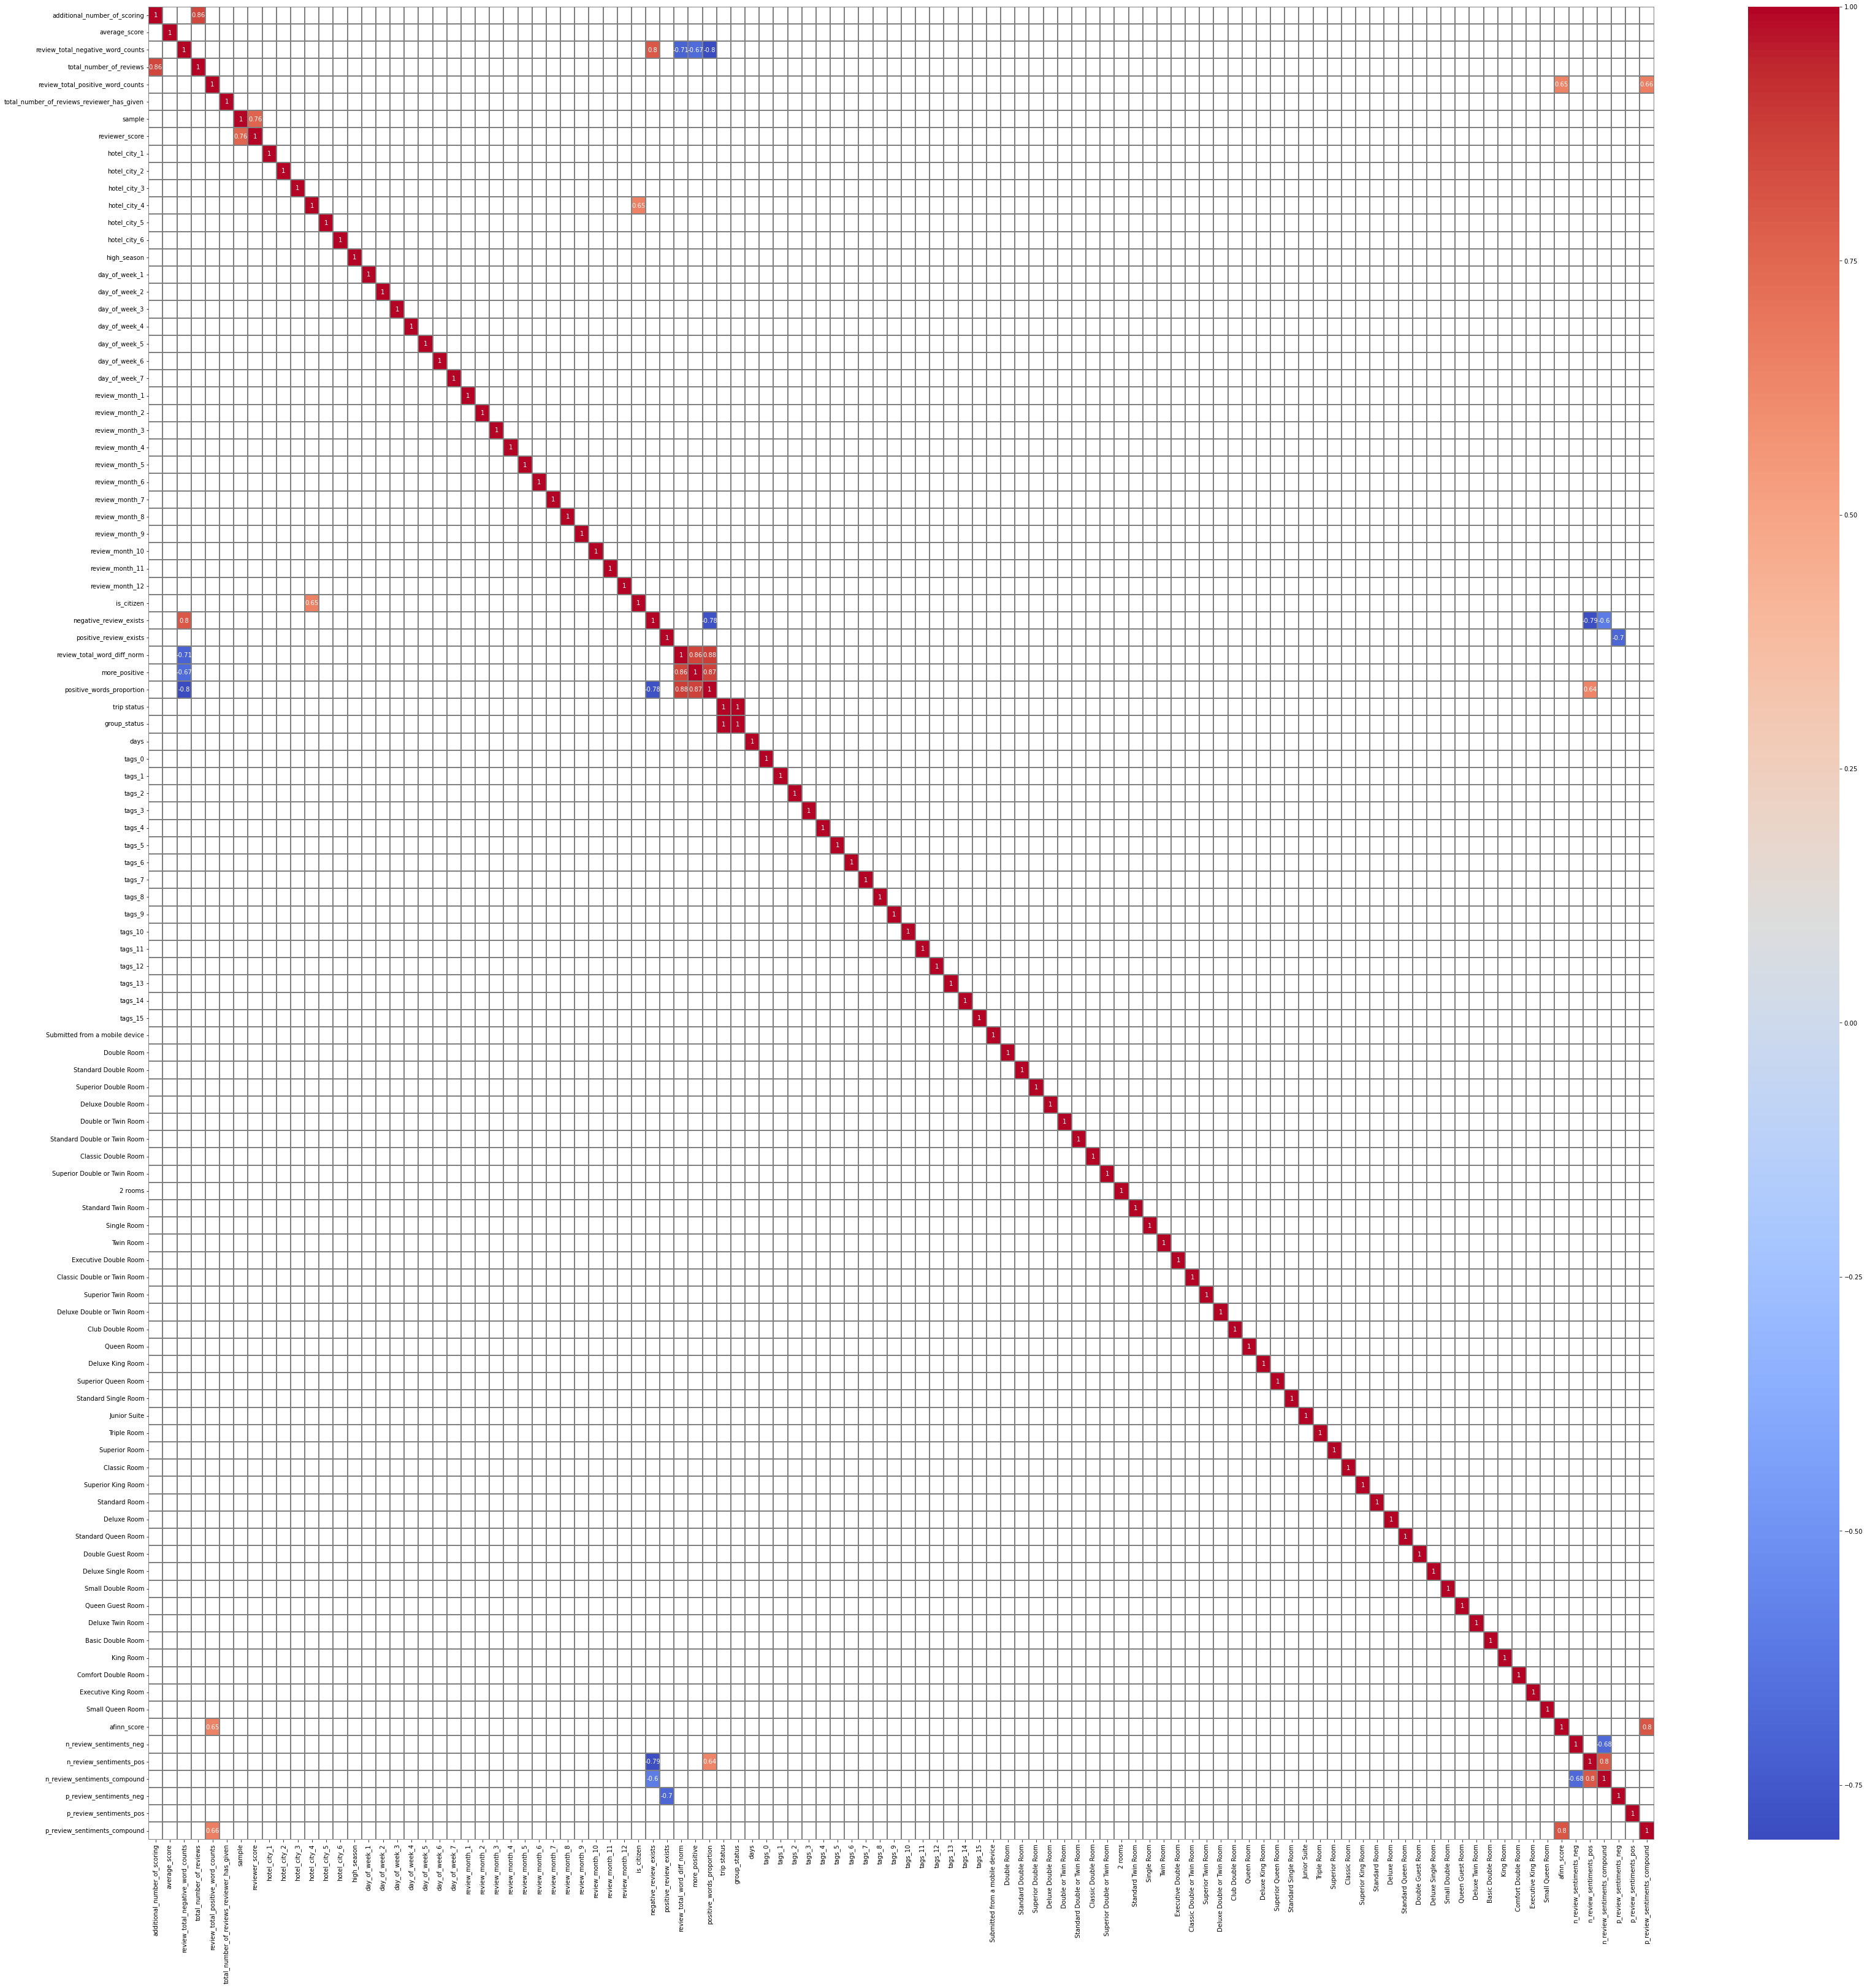

In [568]:
# Для корреляции с категориальными признаками будем использовать метод Спирмена
corr = hotels.corr(method = 'spearman')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.6
mask_2 = np.abs(corr) <= -0.6

corr_data = corr[mask_1 | mask_2]


# проверка признака на мультиколлинеарность
plt.rcParams['figure.figsize'] = (55,55)
sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')
# sns.heatmap(corr, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')

In [569]:
# hotels.nunique()

In [570]:
# Убираются признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object"  и "category" обучаться не будет, просто их удалим.
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
category_columns = [с for с in hotels.columns if hotels[с].dtypes.name == 'category']
hotels.drop(object_columns, axis = 1, inplace=True)
hotels.drop(category_columns, axis = 1, inplace=True)

# Также убирается признак с высокой кореляцией: 
hotels.drop(['total_number_of_reviews'],axis=1,inplace=True) # кореллировал с additional_number_of_scoring. 
# (Убрал именно так опытным путём, по скорингу.) 

# По опыту, если удалить скоринг вырастет на 4 тысячных, можно убрать, а можно и нет...
drop_columns = ['more_positive', 'Small Queen Room', 'Comfort Double Room', 
                'Executive King Room', 'Superior King Room', 'Standard Queen Room',
                'Double Guest Room', 'Basic Double Room', 
                'King Room', 'Deluxe Twin Room']

hotels.drop(drop_columns, axis = 1, inplace=True)

<AxesSubplot:>

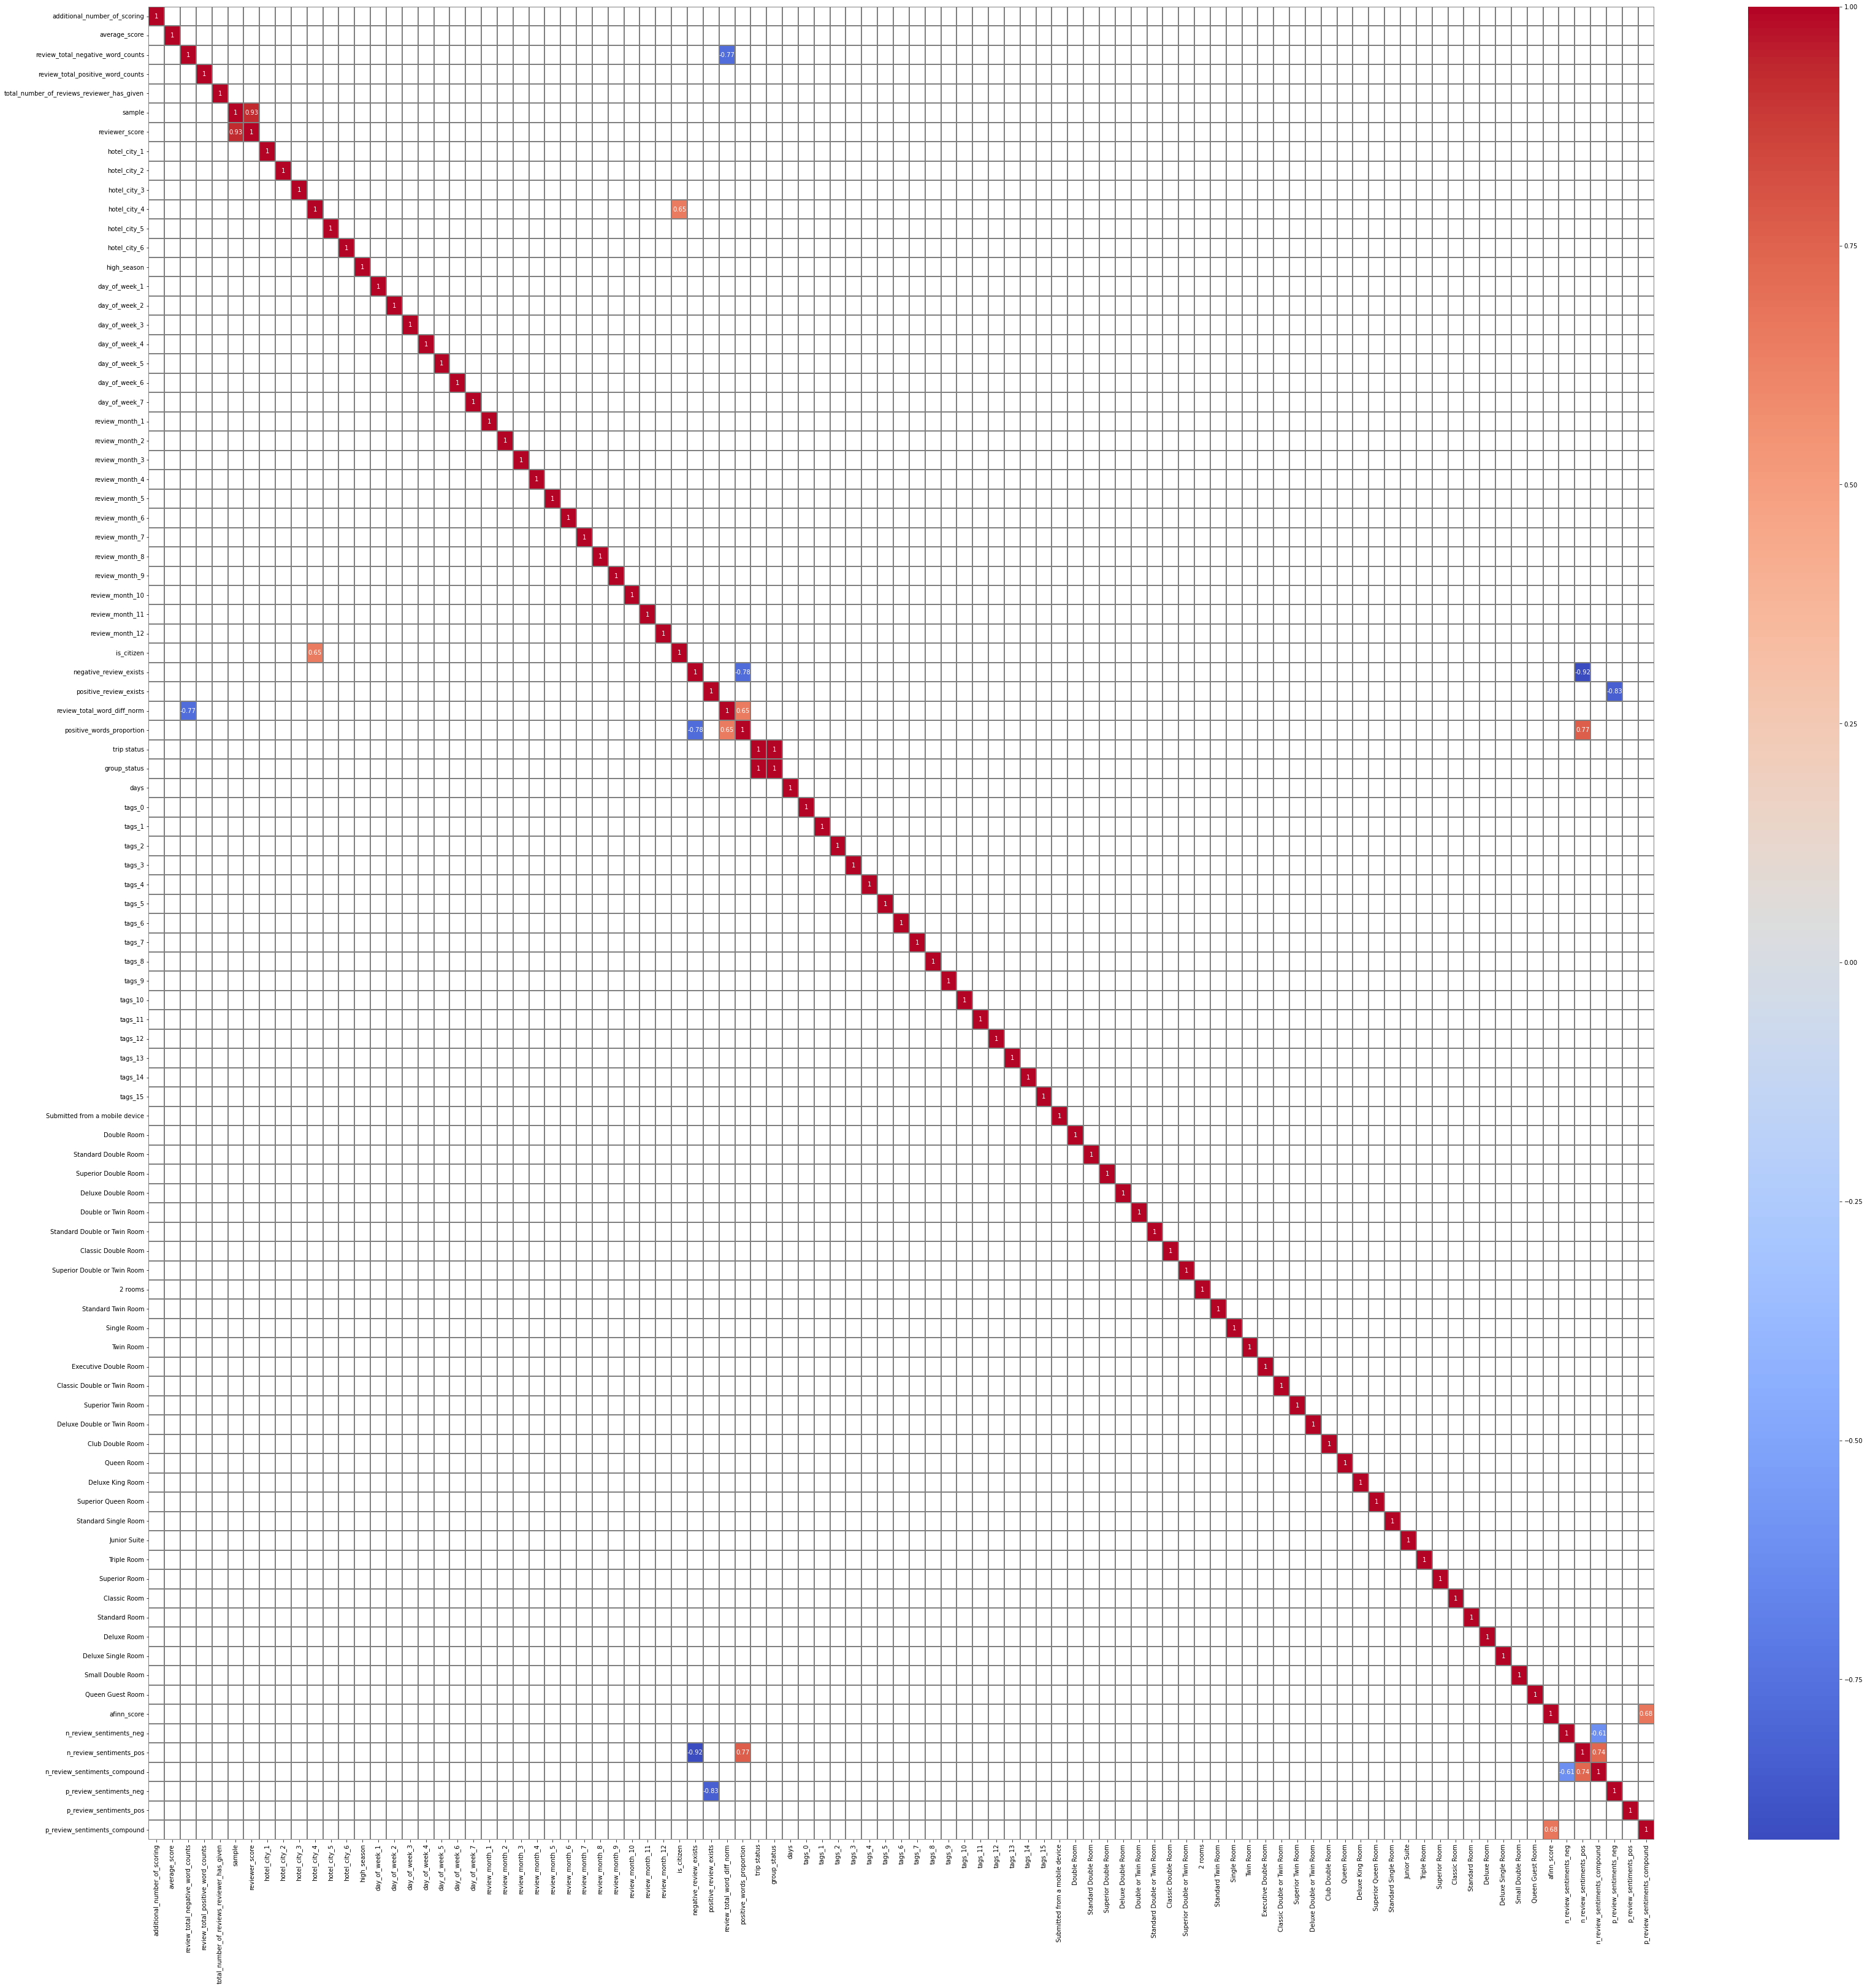

In [571]:
# для корреляции с непрерывными признаками будем использовать метод Пирсона
corr = hotels.corr(method='pearson')

# выведем только данные с высоким уровнем корреляции
mask_1 = np.abs(corr) >= 0.6
mask_2 = np.abs(corr) <= -0.6
corr_data = corr[mask_1 | mask_2]


# проверка признака на мультиколлинеарность
plt.rcParams['figure.figsize'] = (55,55)
sns.heatmap(corr_data, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')
# sns.heatmap(corr, annot=True, cmap='coolwarm', linewidth=0.3, linecolor='gray')

In [572]:
# hotels.info()

In [573]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [574]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [575]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 94), (386803, 94), (386803, 93), (309442, 93), (77361, 93))

In [576]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [577]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [578]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.2s finished


In [579]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
# print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8497721073926134


<AxesSubplot:>

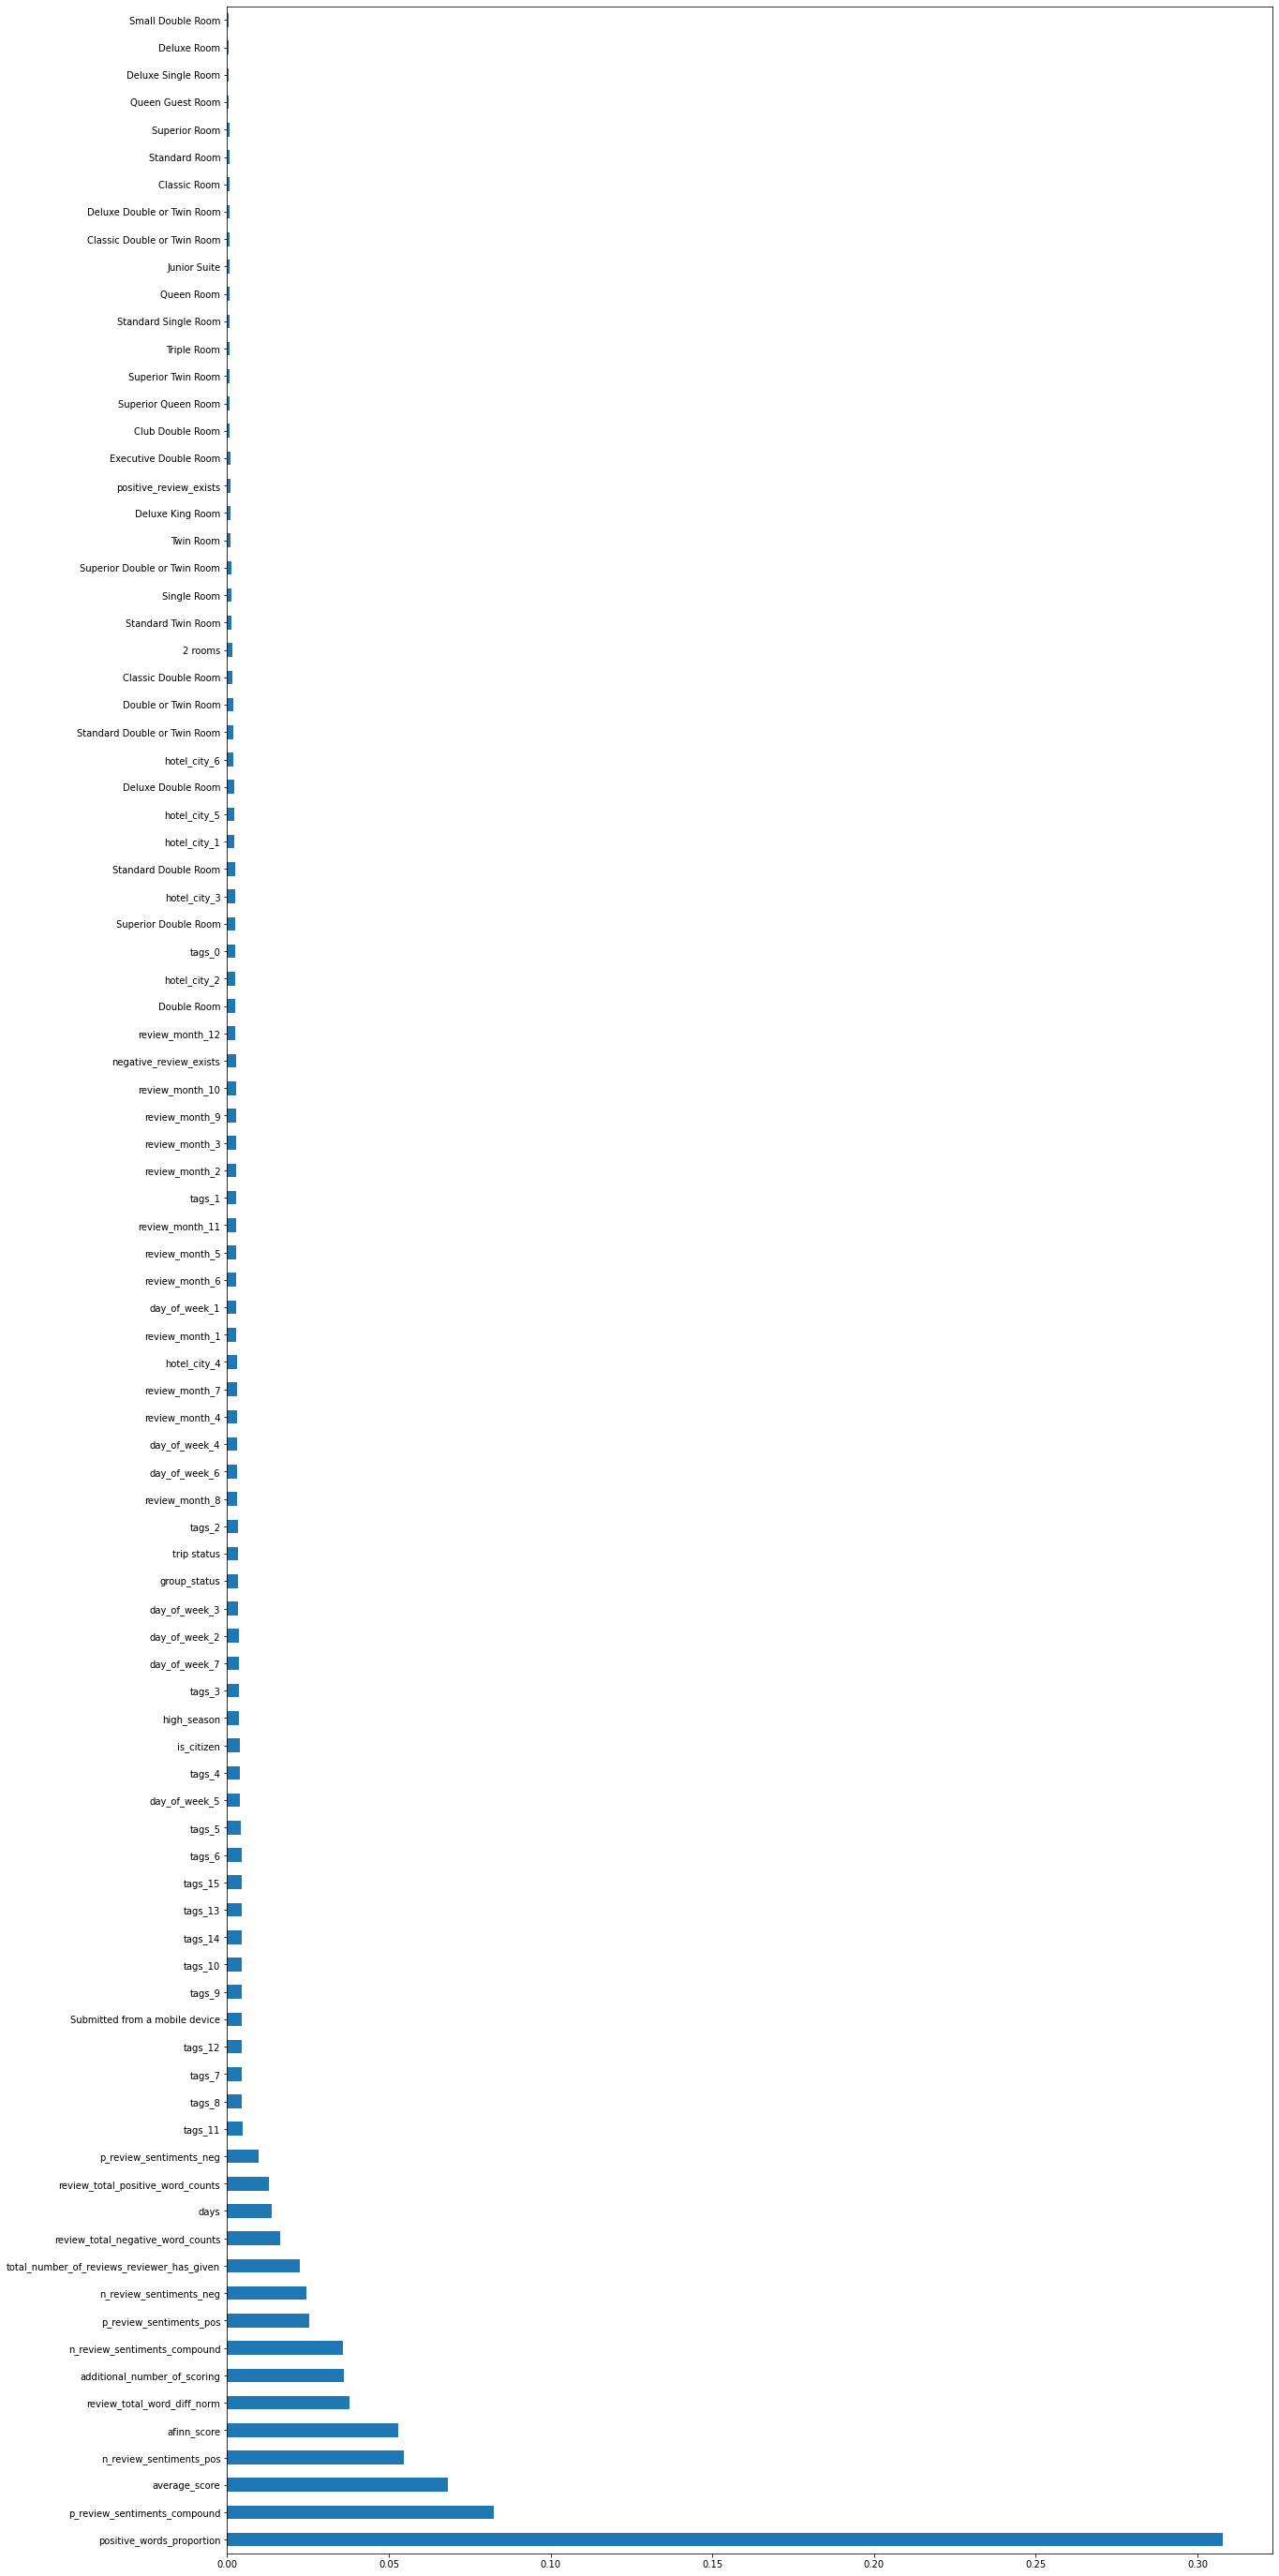

In [580]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (20,50)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(feat_importances)).plot(kind='barh')


In [581]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,hotel_city_1,hotel_city_2,hotel_city_3,hotel_city_4,...,Deluxe Single Room,Small Double Room,Queen Guest Room,afinn_score,n_review_sentiments_neg,n_review_sentiments_pos,n_review_sentiments_compound,p_review_sentiments_neg,p_review_sentiments_pos,p_review_sentiments_compound
95094,365,8.100,21,2,6,0.000,0,0,0,1,...,0,0,0,-2.000,0.135,0.000,-0.202,0.000,0.000,0.000
107187,85,9.100,11,17,4,0.000,0,0,0,1,...,0,0,0,7.000,0.174,0.304,0.361,0.000,0.444,0.832
1489,75,8.700,0,42,21,0.000,0,0,1,0,...,0,0,0,10.000,0.000,1.000,0.557,0.000,0.339,0.937
48852,452,7.600,4,14,19,0.000,0,0,0,1,...,0,0,0,6.000,0.667,0.000,-0.250,0.000,0.398,0.765
111179,806,7.800,0,20,4,0.000,0,0,0,1,...,0,0,0,3.000,0.000,1.000,0.557,0.000,0.204,0.625
78498,926,8.200,21,9,1,0.000,0,1,0,0,...,0,0,0,7.000,0.000,0.000,0.000,0.000,0.729,0.895
20987,417,8.900,0,28,5,0.000,0,0,0,1,...,0,0,0,18.500,0.000,1.000,0.557,0.000,0.677,0.990
79423,704,8.800,2,0,5,0.000,0,0,0,1,...,0,0,0,1.000,0.000,1.000,0.932,0.379,0.621,0.340
89331,137,8.600,26,99,10,0.000,0,0,0,1,...,0,0,0,18.500,0.052,0.482,0.940,0.000,0.231,0.979
49161,474,8.200,21,4,5,0.000,0,1,0,0,...,0,0,0,5.000,0.068,0.311,0.805,0.000,0.592,0.440


In [582]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [583]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [584]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished


In [585]:
predict_submission

array([8.434, 7.497, 8.352, ..., 8.018, 9.645, 7.196])

In [586]:
list(sample_submission)

['reviewer_score', 'id']

In [587]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.434,488440
1,7.497,274649
2,8.352,374688
3,9.876,404352
4,9.533,451596
5,8.690,302161
6,8.112,317079
7,7.476,13963
8,8.739,159785
9,7.382,195089
